In [19]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import linear_model
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
from utils import *
import numpy as np
pd.set_option('display.max_rows', 500)

In [20]:
# MLQE

In [21]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
ds = 'TAC_11.csv'

# Analysis by Systems 

### Build Borda Count

In [22]:
switch = True

In [24]:
X_train.shape

(19, 240)

In [30]:
all_explained = {
    'Explained Variance': [],'Component':[],'Dataset':[]
}
n_max = 20
for ds in AVAILBLE_DATASETS:
    considered_df_system = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
    assert considered_df_system.shape[0] % considered_df_system.loc[0].shape[0] == 0
    nbs_system = considered_df_system.shape[0] // considered_df_system.loc[0].shape[0] 
    nbs_utt = considered_df_system.loc[0].shape[0] 
    dic = {}

    for column in list(considered_df_system.columns):
        print(column)
        dic['borda_{}'.format(column)] = []
        for i in range(nbs_system): 
            current_borda_count = np.argsort(np.argsort(considered_df_system.loc[i][column].values)).tolist()
            dic['borda_{}'.format(column)] += current_borda_count
    dic['System'] = sum([['M{}'.format(i)]*nbs_utt for i in range(nbs_system)],[])
    dic['Utt'] = sum([['U{}'.format(i) for i in range(nbs_utt)]* nbs_system],[])
    df_borda_system = pd.DataFrame(dic).set_index('System')
    df_borda_system.head()
    human_metric = [ i for i in df_borda_system.columns if ('H:' in i and 'Utt' not in i)]
    other_metric = [ i for i in df_borda_system.columns if ('H:' not in i and 'Utt' not in i)]
    print("Human", human_metric)
    print("Other", other_metric)
    X_train = df_borda_system.values[:,:-1]
    if switch :
        X_train = np.transpose(X_train)
        break

    pca = PCA(n_components=X_train.shape[0])
    scaler = StandardScaler()
    projected = pca.fit_transform(scaler.fit_transform(X_train))
    all_explained['Explained Variance'] += list(pca.explained_variance_ratio_) + [
        0] * (n_max - len(pca.explained_variance_ratio_))
    size = len(list(pca.explained_variance_ratio_) + [
        0] * (n_max - len(pca.explained_variance_ratio_)))
    all_explained['Dataset'] += size * [ds.replace('.csv',"")]
    all_explained['Component'] += list(range(n_max))

H:engaging
H:context
H:natural
H:overall
H:understandable
H:useknowledge
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore
Human ['borda_H:engaging', 'borda_H:context', 'borda_H:natural', 'borda_H:overall', 'borda_H:understandable', 'borda_H:useknowledge']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


In [47]:
np.sum(projected[:,0]**2)

1167.1418419423148

In [67]:
a = np.abs(projected[:,0] / np.sqrt(np.sum(projected[:,0]**2)))
np.array(considered_df_system.columns)[a>0.31]

array(['H:engaging', 'H:natural', 'BLEU'], dtype=object)

In [62]:
a = np.abs(projected[:,1] / np.sqrt(np.sum(projected[:,1]**2)))
np.array(considered_df_system.columns)[a>0.3]

array(['Chrfpp', 'BERTScore', 'MoverScore'], dtype=object)

[0.26477809 0.13607   ]


Text(0, 0.5, 'component 2')

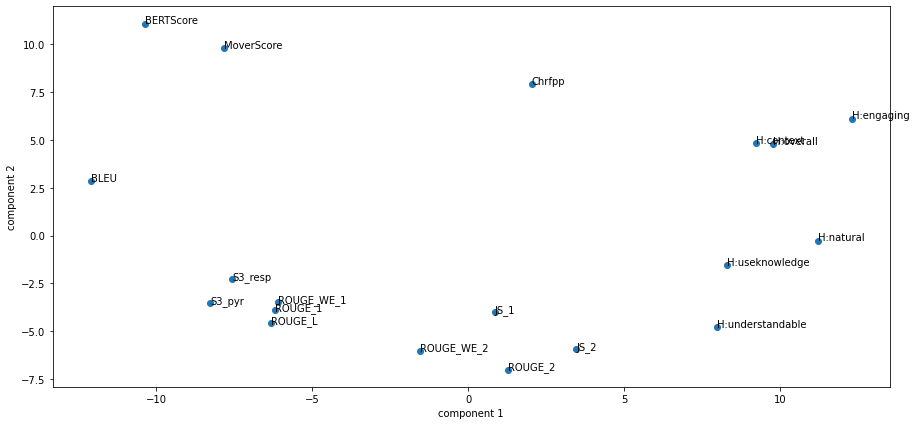

In [39]:
pca = PCA(n_components=2)
scaler = StandardScaler()
projected = pca.fit_transform(scaler.fit_transform(X_train))
print(pca.explained_variance_ratio_)
plt.figure(figsize=(15,7))
x = projected[:, 0].tolist()
y =  projected[:, 1].tolist()
plt.scatter(x,y)

for i, txt in enumerate(list(considered_df_system.columns)):
    plt.annotate(txt, (x[i], y[i]))
    
plt.scatter

plt.xlabel('component 1')
plt.ylabel('component 2')

In [ ]:
# BARPLOT : 
X metrics
Y la contribution de chaque vecteur propre

(2, 240)

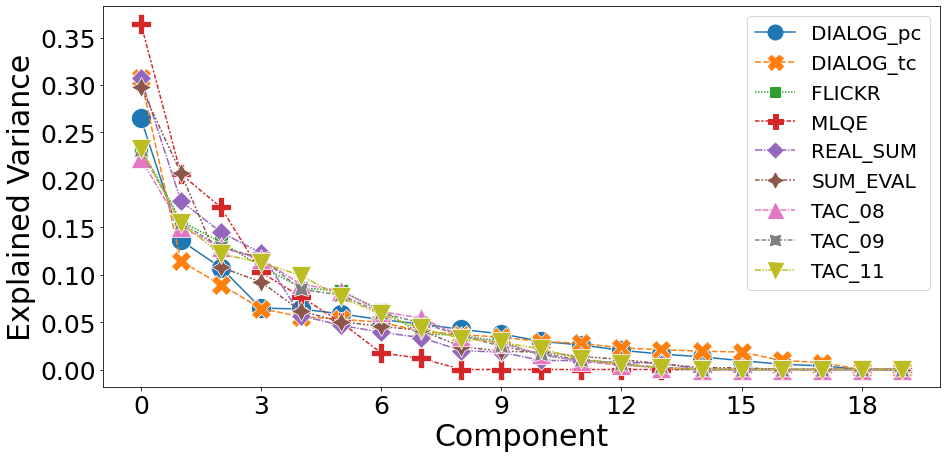

In [26]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(15,7))
ax = sns.lineplot(data=pd.DataFrame(all_explained),  markers=True, markersize=20,
                  x="Component", y="Explained Variance",style="Dataset" ,  hue="Dataset")
plt.setp(ax.get_xticklabels(), fontsize=25,ha='center')
plt.setp(ax.get_yticklabels(), fontsize=25)
lgd = plt.legend(prop={'size': 20},markerscale=2.5)
plt.xlabel('Component', fontsize=30)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Explained Variance', fontsize=30)
plt.savefig('pca_sys_level.pdf',format= 'pdf')

# Analysis by utterance 

In [27]:
all_explained = {
    'Explained Variance': [],'Component':[],'Dataset':[]
}
n_max = 20
for ds in AVAILBLE_DATASETS:
    if 'MLQE' not in ds:
        considered_df_utterance = pd.read_csv(os.path.join(data_path,ds)).set_index(['Utterance','System'])
        assert considered_df_utterance.shape[0] % considered_df_utterance.loc['M0'].shape[0] == 0
        nbs_utt = considered_df_utterance.shape[0] // considered_df_utterance.loc['M0'].shape[0] 
        nbs_system = considered_df_utterance.loc['M0'].shape[0] 
        print(nbs_system,nbs_utt)

        dic_utterance = {}

        for column in list(considered_df_utterance.columns):
            print(column)
            dic_utterance['borda_{}'.format(column)] = []
            for i in range(nbs_utt): 
                current_borda_count = np.argsort(np.argsort(
                    considered_df_utterance.loc['M{}'.format(i)][column].values)).tolist()
                dic_utterance['borda_{}'.format(column)] += current_borda_count
        dic_utterance['System'] = sum([['M{}'.format(i) for i in range(nbs_system)]*nbs_utt],[]) # TODO : pas sur
        dic_utterance['Utt'] = sum([['U{}'.format(i)]* nbs_utt  for i in range(nbs_system)],[])
        df_borda_utterance = pd.DataFrame(dic_utterance).set_index('Utt')
        human_metric = [ i for i in df_borda_utterance.columns if ('H:' in i and 'System' not in i)]
        other_metric = [ i for i in df_borda_utterance.columns if ('H:' not in i and 'System' not in i)]
        print("Human", human_metric)
        print("Other", other_metric)
        X_train_utterance = df_borda_utterance.values[:,:-1]
        if switch :
            X_train_utterance = np.transpose(X_train_utterance)
        pca = PCA(n_components=X_train_utterance.shape[0])
        scaler = StandardScaler()
        projected = pca.fit_transform(scaler.fit_transform(X_train_utterance))
        all_explained['Explained Variance'] += list(pca.explained_variance_ratio_) + [
            0] * (n_max - len(pca.explained_variance_ratio_))
        size = len(list(pca.explained_variance_ratio_) + [
            0] * (n_max - len(pca.explained_variance_ratio_)))
        all_explained['Dataset'] += size * [ds.replace('.csv',"")]
        all_explained['Component'] += list(range(n_max))

60 4
H:engaging
H:context
H:natural
H:overall
H:understandable
H:useknowledge
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore
Human ['borda_H:engaging', 'borda_H:context', 'borda_H:natural', 'borda_H:overall', 'borda_H:understandable', 'borda_H:useknowledge']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']
60 5
H:engaging
H:context
H:natural
H:overall
H:understandable
H:useknowledge
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore
Human ['borda_H:engaging', 'borda_H:context', 'borda_H:natural', 'borda_H:overall', 'borda_H:understandable', 'borda_H:useknowledge']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1'

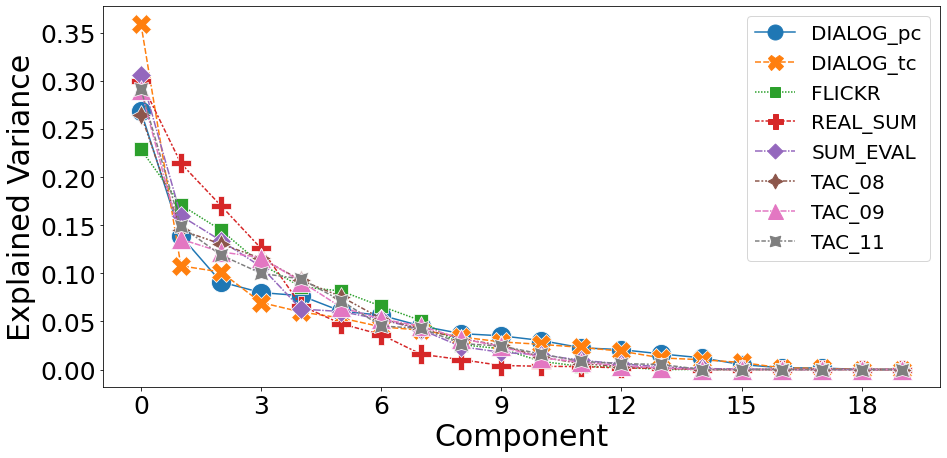

In [28]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(15,7))
ax = sns.lineplot(data=pd.DataFrame(all_explained),  markers=True, markersize=20,
                  x="Component", y="Explained Variance",style="Dataset" ,  hue="Dataset")
plt.setp(ax.get_xticklabels(), fontsize=25,ha='center')
plt.setp(ax.get_yticklabels(), fontsize=25)
lgd = plt.legend(prop={'size': 20},markerscale=2.5)
plt.xlabel('Component', fontsize=30)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Explained Variance', fontsize=30)
plt.savefig('pca_utt_level.pdf',format= 'pdf')

In [37]:
considered_df_utterance = pd.read_csv(os.path.join(data_path,ds)).set_index(['Utterance','System'])
assert considered_df_utterance.shape[0] % considered_df_utterance.loc['M0'].shape[0] == 0
nbs_utt = considered_df_utterance.shape[0] // considered_df_utterance.loc['M0'].shape[0] 
nbs_system = considered_df_utterance.loc['M0'].shape[0] 
print(nbs_system,nbs_utt)

dic_utterance = {}

for column in list(considered_df_utterance.columns):
    print(column)
    dic_utterance['borda_{}'.format(column)] = []
    for i in range(nbs_utt): 
        current_borda_count = np.argsort(np.argsort(
            considered_df_utterance.loc['M{}'.format(i)][column].values)).tolist()
        dic_utterance['borda_{}'.format(column)] += current_borda_count
dic_utterance['System'] = sum([['M{}'.format(i) for i in range(nbs_system)]*nbs_utt],[]) # TODO : pas sur
dic_utterance['Utt'] = sum([['U{}'.format(i)]* nbs_utt  for i in range(nbs_system)],[])
df_borda_utterance = pd.DataFrame(dic_utterance).set_index('Utt')
human_metric = [ i for i in df_borda_utterance.columns if ('H:' in i and 'System' not in i)]
other_metric = [ i for i in df_borda_utterance.columns if ('H:' not in i and 'System' not in i)]
print("Human", human_metric)
print("Other", other_metric)
X_train_utterance = df_borda_utterance.values[:,:-1]


[0.29156392 0.148843  ]
('M0', 'U2')
('M0', 'U3')
('M0', 'U4')
('M0', 'U5')
('M0', 'U6')
('M0', 'U7')
('M0', 'U8')
('M0', 'U9')
('M0', 'U10')
('M0', 'U13')
('M0', 'U14')


IndexError: list index out of range

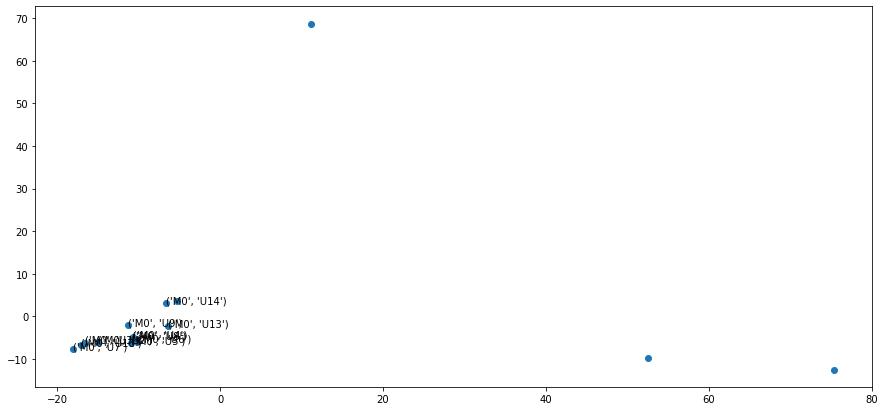